In [24]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath('.'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
dendritex_path = os.path.join(project_root, 'dendritex')
sys.path.insert(0, dendritex_path)

import time
import brainstate as bst
import braintools as bts
import brainunit as u
import jax
import matplotlib.pyplot as plt
import numpy as np
import dendritex as dx

bst.environ.set(precision=64)

#jax.config.update("jax_disable_jit", True)

In [25]:
## morphology params
loaded_params = np.load('golgi_morphology.npz')

connection = loaded_params['connection']
L = loaded_params['L']               # um
diam = loaded_params['diam']         # um
Ra = loaded_params['Ra']             # ohm * cm
cm = loaded_params['cm']             # uF / cm ** 2

n_neuron = 1
n_compartments = len(L)
size = (n_neuron,n_compartments)

index_soma = loaded_params['index_soma']
index_axon = loaded_params['index_axon']
index_dend_basal = loaded_params['index_dend_basal']
index_dend_apical = loaded_params['index_dend_apical']

## conductvalues 
conductvalues = 1e3 * np.array([

  0.00499506303209, 0.01016375552607, 0.00247172479141, 0.00128859564935,
  3.690771983E-05, 0.0080938853146, 0.01226052748146, 0.01650689958385,
  0.00139885617712, 0.14927733727426, 0.00549507510519, 0.14910988921938,
  0.00406420380423, 0.01764345789036, 0.10177335775222, 0.0087689418803,
  3.407734319E-05, 0.0003371456442, 0.00030643090764, 0.17233663543619,
  0.00024381226198, 0.10008178886943, 0.00595046001148, 0.0115, 0.0091
])

## IL 
gl = np.ones(n_compartments)
gl[index_soma] = 0.03
gl[index_axon] = 0.001
gl[index_axon[0]] = 0.03
gl[index_dend_basal] = 0.03
gl[index_dend_apical] = 0.03

## IKv11_Ak2007
gkv11 = np.zeros(n_compartments)
gkv11[index_soma] = conductvalues[10]

## IKv34_Ma2020  
gkv34 = np.zeros(n_compartments)
gkv34[index_soma] = conductvalues[11]
gkv34[index_axon[1:]] = 9.1

## IKv43_Ma2020
gkv43 = np.zeros(n_compartments)
gkv43[index_soma] = conductvalues[12]

## ICaGrc_Ma2020
gcagrc = np.zeros(n_compartments)
gcagrc[index_soma] = conductvalues[15]
gcagrc[index_dend_basal] = conductvalues[8]
gcagrc[index_axon[0]] = conductvalues[22]

## ICav23_Ma2020
gcav23 =  np.zeros(n_compartments)
gcav23[index_dend_apical] = conductvalues[3]

## ICav31_Ma2020 
gcav31 =  np.zeros(n_compartments)
gcav31[index_soma] = conductvalues[16]
gcav31[index_dend_apical] = conductvalues[4]

## INa_Rsg
gnarsg = np.zeros(n_compartments)
gnarsg [index_soma] = conductvalues[9]
gnarsg[index_dend_apical] = conductvalues[0]
gnarsg[index_dend_basal] =  conductvalues[5]
gnarsg[index_axon[0]] = conductvalues[19]
gnarsg[index_axon[1:]] = 11.5

## Ih1_Ma2020 
gh1 = np.zeros(n_compartments)
gh1[index_axon[0]] = conductvalues[17]

## Ih1_Ma2020 
gh2 = np.zeros(n_compartments)
gh2[index_axon[0]] = conductvalues[18]

## IKca3_1_Ma2020 
gkca31 = np.zeros(n_compartments)
gkca31[index_soma] =  conductvalues[14]

In [26]:
# single ion test
connection = ((1,2),(2,3))
gl = np.zeros(n_compartments) 
g_test =  np.zeros(n_compartments) 
g_test[index_soma] = 2.5e-4

In [27]:
class Golgi(dx.neurons.MultiCompartment):
  def __init__(self, size, connection, Ra, cm, diam, L, gl, g_test):
    super().__init__(
      size=size,
      connection=connection,
      Ra=Ra * u.ohm * u.cm,
      cm=cm * u.uF / u.cm ** 2,
      diam=diam * u.um,
      L=L * u.um,
      V_th=20. * u.mV,
      V_initializer=bst.init.Constant(-55 * u.mV),
      spk_fun=bst.surrogate.ReluGrad(),
    )

    self.IL = dx.channels.IL(self.size, E=-55. * u.mV, g_max=gl * u.mS / (u.cm ** 2))
    #self.Ih1 = dx.channels.Ih1_Ma2020(self.size, E=-20. * u.mV, g_max=g_test * u.mS / (u.cm ** 2))
    self.k = dx.ions.PotassiumFixed(self.size, E=-80. * u.mV)
    self.k.add_elem(dx.channels.IKM_Grc_Ma2020(self.size, g_max=g_test * u.mS / (u.cm ** 2)))
    #self.ca = dx.ions.CalciumFixed(self.size, E=137.* u.mV, C =5e-5 * u.mM)
    #self.ca.add_elem(dx.channels.ICav31_Ma2020(self.size, g_max=g_test * (u.cm / u.second)))
    #self.kca = dx.MixIons(self.k, self.ca)
    #self.kca.add_elem(dx.channels.IKca1_1_Ma2020(self.size, g_max=g_test * u.mS / (u.cm ** 2)))

kvaerno5 {'max_steps': None, 'num_accepted_steps': Array(13, dtype=int64, weak_type=True), 'num_rejected_steps': Array(13, dtype=int64, weak_type=True), 'num_steps': Array(26, dtype=int64, weak_type=True)}
time 6.803005695343018
ieuler {'max_steps': None, 'num_accepted_steps': Array(75, dtype=int64, weak_type=True), 'num_rejected_steps': Array(17, dtype=int64, weak_type=True), 'num_steps': Array(92, dtype=int64, weak_type=True)}
time 5.315016984939575
rk4 200000
time 14.174999952316284


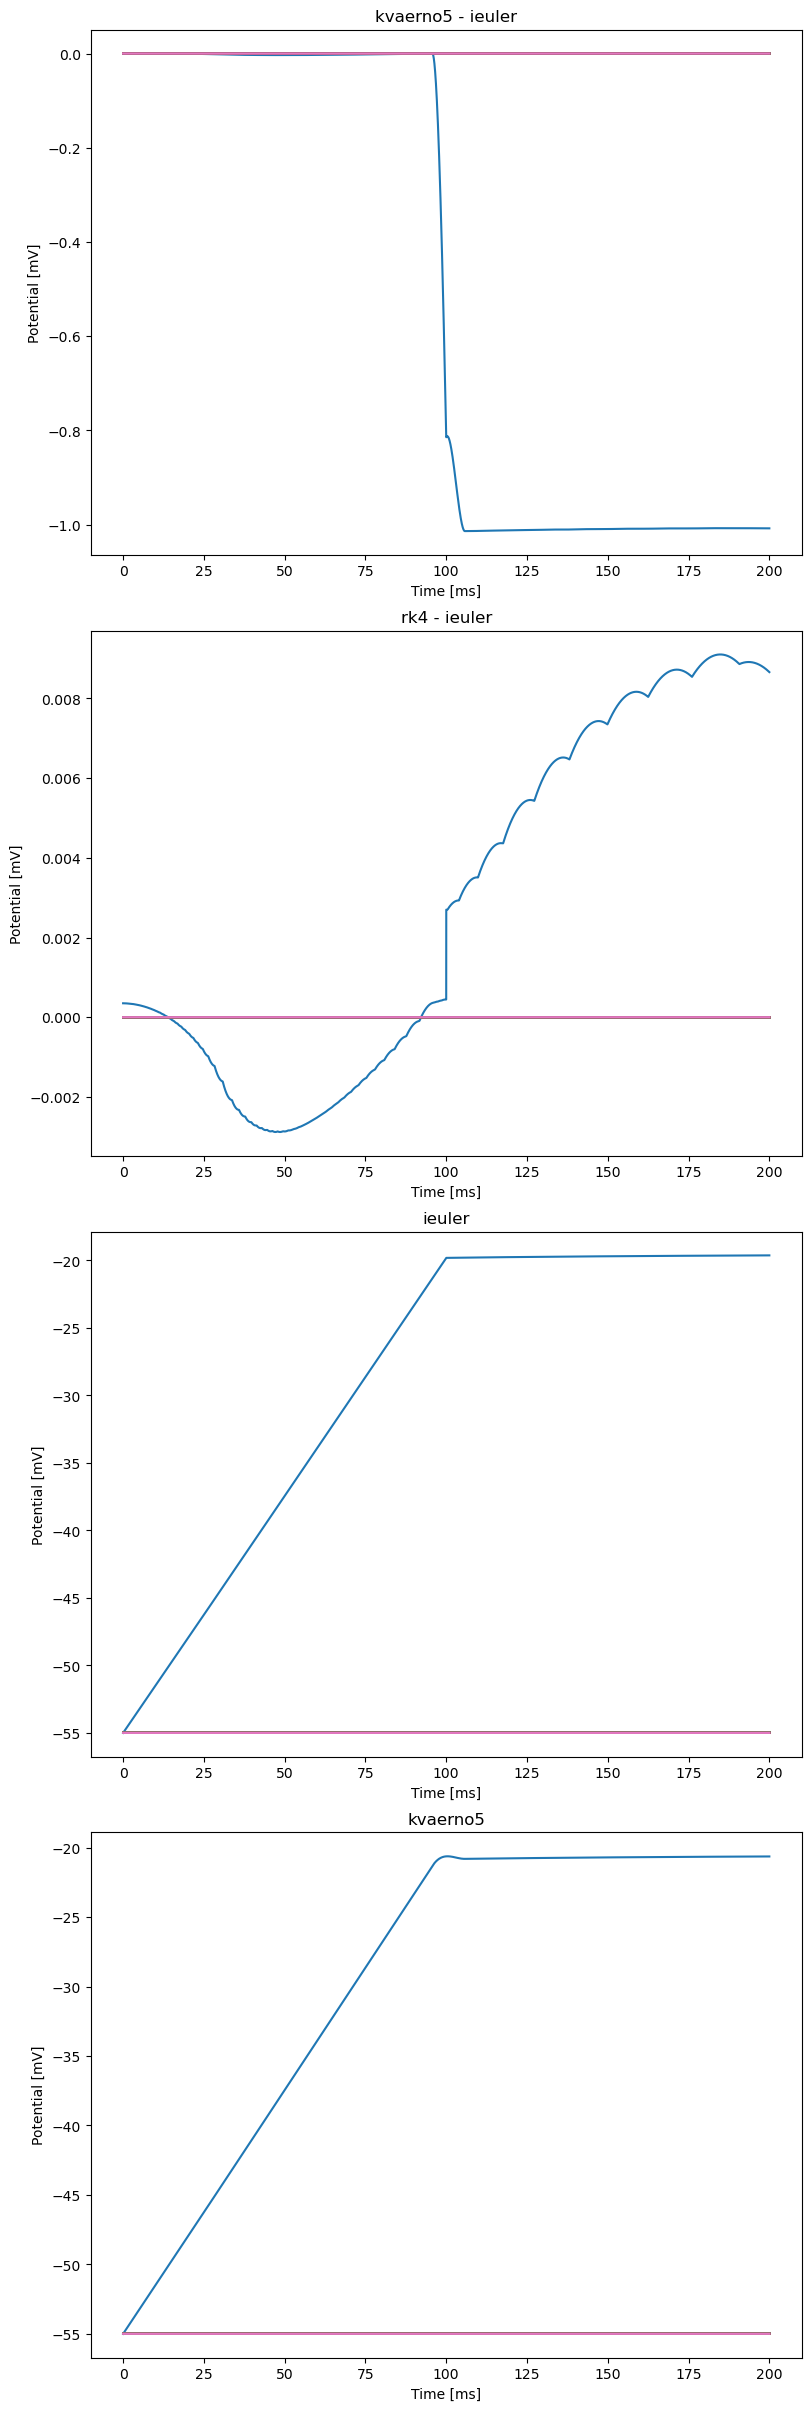

In [28]:
@bst.transform.jit(static_argnums=6)
def simulate(Ra, cm, diam, L, gl, gkv11, method='ieuler'):
  cell = Golgi(size, connection, Ra, cm, diam, L, gl, gkv11)
  cell.init_state()
  cell.reset_state()

  def step(t, *args):
    inp_a = np.full((n_neuron, n_compartments), 0.) * u.nA
    inp_a[..., 0] = 0.002 * u.nA
    inp_b = np.full((n_neuron, n_compartments), 0.) * u.nA
    cell.compute_derivative(u.math.where(t < 100 * u.ms, inp_a, inp_b))

  def save(t, *args):
    return cell.V.value

  with jax.ensure_compile_time_eval():
    dt = 0.01 * u.ms
    ts = u.math.arange(0. * u.ms, 200. * u.ms, dt)
  ts, ys, steps = dx.diffrax_solve(
    step, method, 0. * u.ms, 200. * u.ms, dt, ts,
    savefn=save, atol=1e-5,  # max_steps=200000,
  )

  return ts, ys, steps


@bst.transform.jit
def simulate2(Ra, cm, diam, L, gl, gkv11):
  cell = Golgi(size, connection, Ra, cm, diam, L, gl, gkv11)
  cell.init_state()
  cell.reset_state()

  def step_run(t):
    inp_a = np.full((n_neuron, n_compartments), 0.) * u.nA
    inp_a[..., 0] = 0.002 * u.nA
    inp_b = np.full((n_neuron, n_compartments), 0.) * u.nA
    inp = u.math.where(t < 100 * u.ms, inp_a, inp_b)
    dx.rk4_step(cell, t, inp)
    return cell.V.value

  with jax.ensure_compile_time_eval():
    dt = 0.001 * u.ms
    ts = u.math.arange(0. * u.ms, 200. * u.ms, dt)
  with bst.environ.context(dt=dt):
    ys = bst.transform.for_loop(step_run, ts)
  return ts, ys[::10], ts.size

def visualize_a_simulate(Ra, cm, diam, L, gl, gkv11):
  t0 = time.time()
  ts, ys_kvaerno5, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'kvaerno5')
  print('kvaerno5', steps)
  print('time', time.time() - t0)

  t0 = time.time()
  ts, ys_ieuler, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'ieuler')
  print('ieuler', steps)
  print('time', time.time() - t0)

  '''
  t0 = time.time()
  ts, ys_tsit5, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'tsit5')
  print('tsit5', steps)
  print('time', time.time() - t0)

  t0 = time.time()
  ts, ys_dopri5, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'dopri5')
  print('dopri5', steps)
  print('time', time.time() - t0)
  '''
  t0 = time.time()
  ts2, ys2_rk4, steps = simulate2(Ra, cm, diam, L, gl, gkv11)
  print('rk4', steps)
  print('time', time.time() - t0)
  
  def plot(data, ax, title):
    ax.plot(ts.to_decimal(u.ms), u.math.squeeze(data.to_decimal(u.mV)))
    plt.xlabel('Time [ms]')
    plt.ylabel('Potential [mV]')
    plt.title(title)

  fig, gs = bts.visualize.get_figure(4, 1, 6.0, 8.0)
  plot(ys_kvaerno5 - ys_ieuler, fig.add_subplot(gs[0, 0]), 'kvaerno5 - ieuler')
  #plot(ys_ieuler - ys_tsit5, fig.add_subplot(gs[0, 1]), 'ieuler - tsit5')
  #plot(ys_tsit5 - ys_dopri5, fig.add_subplot(gs[0, 2]), 'tsit5 - dopri5')
  #plot(ys_dopri5 - ys2_rk4, fig.add_subplot(gs[0, 3]), 'dopri5 - rk4')
  plot(ys2_rk4 - ys_ieuler, fig.add_subplot(gs[1, 0]), 'rk4 - ieuler')
  plot(ys_ieuler, fig.add_subplot(gs[2, 0]), 'ieuler')
  plot(ys_kvaerno5, fig.add_subplot(gs[3, 0]), 'kvaerno5')

  plt.show()

visualize_a_simulate(Ra, cm, diam, L, gl, g_test)